# Keras LSTM benchmark notebook

This notebook explores a different type of model architecture that will capture feature values at previous time steps

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [77]:
#untie local dependency
import os
cwd = os.getcwd().split('\\')
local_repo_path = '\\'.join(cwd[:-1])
raw_data_path = local_repo_path + '\\data\\raw'
processed_data_path = local_repo_path + '\\data\\processed'
feature_path = local_repo_path + '\\data\\features'
submissions_path = local_repo_path + '\\submissions'

# Load data

In [78]:
output_feature_fname = 'Lookback20'
sj_feature_train = pd.read_csv(feature_path + r'\\sj_train_' + output_feature_fname + '.csv', index_col=0)
sj_feature_test = pd.read_csv(feature_path + r'\\sj_test_' + output_feature_fname + '.csv', index_col=0)
iq_feature_train = pd.read_csv(feature_path + r'\\iq_train_' + output_feature_fname + '.csv', index_col=0)
iq_feature_test = pd.read_csv(feature_path + r'\\iq_test_' + output_feature_fname + '.csv', index_col=0)

In [79]:
sj_feature_train.head()

,var1(t-20),var2(t-20),var3(t-20),var4(t-20),var5(t-20),var1(t-19),var2(t-19),var3(t-19),var4(t-19),var5(t-19),...,var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),total_cases
20,-1.081814,-1.183554,-0.759571,-1.272727,-0.542448,-0.559956,-0.583693,-0.214395,-0.272727,-0.541333,...,0.261463,0.477795,0.227273,0.741472,0.746334,0.681254,0.630934,0.727273,0.823792,40
21,-0.559956,-0.583693,-0.214395,-0.272727,-0.541333,0.006304,-0.005017,-0.214395,0.000000,-0.530953,...,0.681254,0.630934,0.727273,0.823792,0.407017,0.384111,0.441041,0.500000,0.893902,27
22,0.006304,-0.005017,-0.214395,0.000000,-0.530953,-0.061121,-0.053519,0.110260,0.227273,-0.510605,...,0.384111,0.441041,0.500000,0.893902,0.244210,0.226899,0.483920,0.727273,0.949625,42
23,-0.061121,-0.053519,0.110260,0.227273,-0.510605,0.144991,0.146063,0.741194,0.500000,-0.479789,...,0.226899,0.483920,0.727273,0.949625,0.517199,0.474983,0.667688,0.500000,0.988991,33
24,0.144991,0.146063,0.741194,0.500000,-0.479789,0.146087,0.157770,0.385911,0.500000,-0.438229,...,0.474983,0.667688,0.500000,0.988991,0.644923,0.578118,0.606432,0.727273,1.010317,43


In [80]:
sj_feature_test.head()

,var1(t-20),var2(t-20),var3(t-20),var4(t-20),var5(t-20),var1(t-19),var2(t-19),var3(t-19),var4(t-19),var5(t-19),...,var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),city,year,weekofyear
0,-0.269426,-0.262578,-0.618683,-0.272727,0.369460,-0.187200,-0.183415,-0.918836,-0.500000,0.246672,...,-0.500000,-0.520492,-0.445389,-0.455470,-0.073507,0.227273,-0.535167,sj,2008,18
1,-0.187200,-0.183415,-0.918836,-0.500000,0.246672,-0.580787,-0.592613,-0.912711,-0.772727,0.133742,...,0.227273,-0.535167,-0.350555,-0.359024,-0.294028,-0.500000,-0.542448,sj,2008,19
2,-0.580787,-0.592613,-0.912711,-0.772727,0.133742,-0.737015,-0.754286,-0.777948,-0.272727,0.149719,...,-0.500000,-0.542448,-0.399342,-0.410314,-0.490046,-0.272727,-0.541333,sj,2008,20
3,-0.737015,-0.754286,-0.777948,-0.272727,0.149719,-0.710703,-0.722509,-0.961715,-0.772727,0.055436,...,-0.272727,-0.541333,-0.060573,-0.054077,0.306279,0.000000,-0.530953,sj,2008,21
4,-0.710703,-0.722509,-0.961715,-0.772727,0.055436,-0.899274,-0.947178,-1.194487,-1.000000,-0.019901,...,0.000000,-0.530953,-0.405372,-0.407526,0.361409,0.727273,-0.510605,sj,2008,22


## Fit and predict with Keras LSTM Neural Network

In [81]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from math import sqrt
from matplotlib import pyplot
from numpy import array
from sklearn.metrics import mean_absolute_error

In [82]:
def fit_and_predict_LSTM(train_wide, test_wide, epochs = 200, n_hidden = 25, activation = 'linear', verbose = 0):
    values = train_wide.values
    n_train = values.shape[0] - 200
    train = values[:n_train, :]
    val = values[n_train:, :]
    
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    val_X, val_y = val[:, :-1], val[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
    test_X = test_wide.drop(['city', 'year', 'weekofyear'], axis = 1).values
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    model = Sequential()
    model.add(LSTM(n_hidden, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.4))
    model.add(Dense(n_hidden))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # fit network
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=72, validation_data=(val_X, val_y), verbose=verbose, shuffle=False)
    
    plt.figure(figsize = (7,5))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()
    
    #build predictions for figure
    test_preds = model.predict(test_X)
    
    train_X_full = values[:,:-1]
    train_preds = model.predict(train_X_full.reshape((train_X_full.shape[0], 1, train_X_full.shape[1])))
    
    fig, ax = plt.subplots(figsize = (20,10))
    train_error = np.round(mean_absolute_error(train_preds, train_wide['total_cases']),1)
    pd.DataFrame(train_preds).plot(ax = ax)
    pd.DataFrame(train_wide['total_cases']).reset_index(drop = True).plot(ax = ax)
    pd.DataFrame(test_preds).set_index(np.arange(len(train_wide), len(train_wide)+ len(test_preds))).plot(ax = ax)
    
    ax.legend(labels = ['Fitted', 'True', 'Predicted'])
    ax.set_title('Mean train error: ' + str(train_error))
    return(model, train_preds, test_preds)

In [83]:
sj_feature_train_log_cases = sj_feature_train.copy()
sj_feature_train_log_cases['total_cases'] = np.log(1 + sj_feature_train_log_cases['total_cases'])

Train on 716 samples, validate on 200 samples
Epoch 1/400
 - 2s - loss: 37.4026 - val_loss: 23.4404
Epoch 2/400
 - 0s - loss: 36.8222 - val_loss: 22.7938
Epoch 3/400
 - 0s - loss: 36.0061 - val_loss: 22.0541
Epoch 4/400
 - 0s - loss: 34.9097 - val_loss: 21.1969
Epoch 5/400
 - 0s - loss: 33.6993 - val_loss: 20.1861
Epoch 6/400
 - 0s - loss: 32.3527 - val_loss: 19.0054
Epoch 7/400
 - 0s - loss: 31.2743 - val_loss: 17.9404
Epoch 8/400
 - 0s - loss: 29.8564 - val_loss: 17.1391
Epoch 9/400
 - 0s - loss: 28.6493 - val_loss: 16.6301
Epoch 10/400
 - 0s - loss: 27.6690 - val_loss: 16.6536
Epoch 11/400
 - 0s - loss: 26.5767 - val_loss: 16.8633
Epoch 12/400
 - 0s - loss: 26.0186 - val_loss: 17.1735
Epoch 13/400
 - 0s - loss: 25.2044 - val_loss: 17.4371
Epoch 14/400
 - 0s - loss: 24.6316 - val_loss: 17.7123
Epoch 15/400
 - 0s - loss: 24.1980 - val_loss: 17.9833
Epoch 16/400
 - 0s - loss: 23.7859 - val_loss: 18.1840
Epoch 17/400
 - 0s - loss: 24.1633 - val_loss: 18.2600
Epoch 18/400
 - 0s - loss: 2

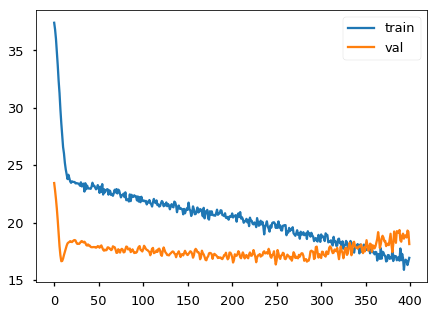

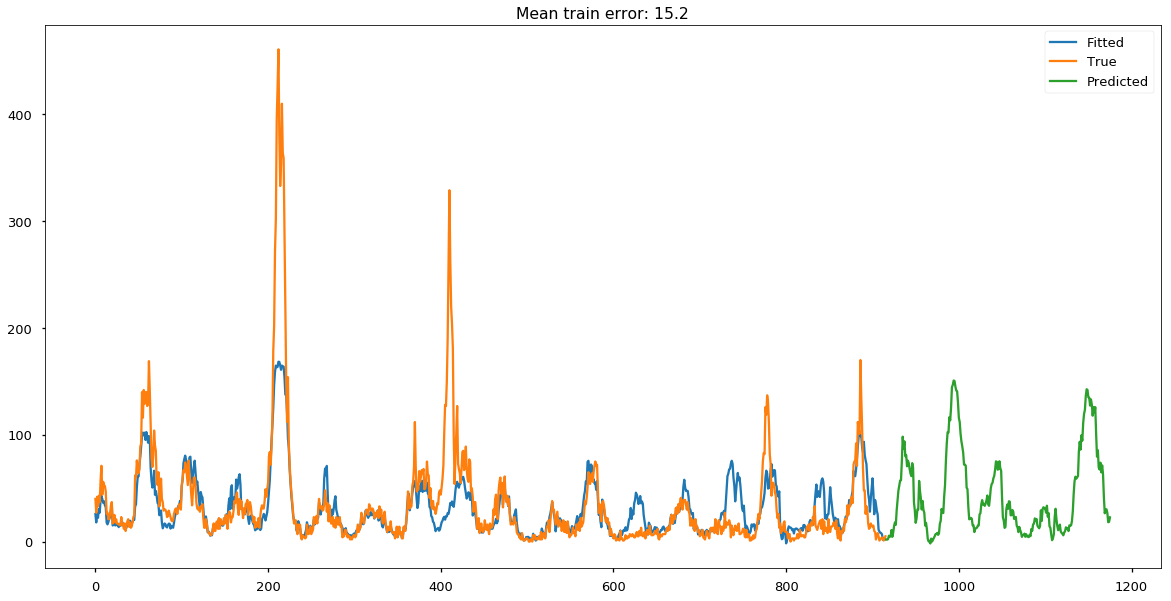

In [84]:
sj_model, sj_train_preds, sj_test_preds = fit_and_predict_LSTM(sj_feature_train, sj_feature_test, epochs = 400, n_hidden = 40, verbose = 2)

In [87]:
output_sj = pd.DataFrame(np.append(sj_train_preds,sj_test_preds))
#output_sj['total_cases'] = np.expm1(output_sj[0]).astype(int)

Text(0,0.5,'total_cases')

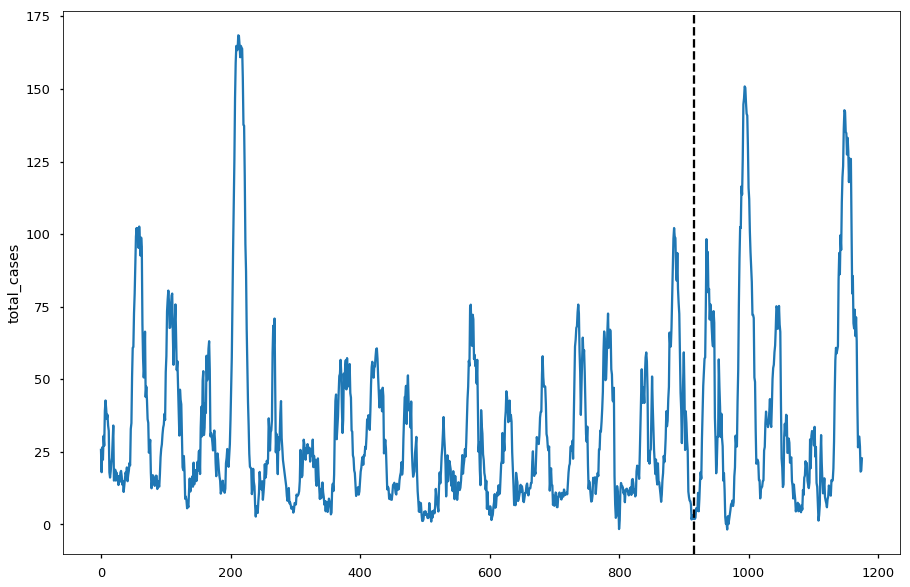

In [88]:
fig, ax = plt.subplots(figsize = (15,10))
output_sj[0].plot(ax = ax)
ax.axvline(len(sj_train_preds), linestyle = 'dashed', color = 'black')
ax.set_ylabel('total_cases')

In [89]:
iq_feature_train_log_cases = iq_feature_train.copy()
iq_feature_train_log_cases['total_cases'] = np.log(1 + iq_feature_train_log_cases['total_cases'])

Train on 230 samples, validate on 200 samples
Epoch 1/50
 - 3s - loss: 8.5722 - val_loss: 8.8855
Epoch 2/50
 - 0s - loss: 8.4020 - val_loss: 8.7904
Epoch 3/50
 - 0s - loss: 8.2566 - val_loss: 8.6894
Epoch 4/50
 - 0s - loss: 8.1341 - val_loss: 8.5793
Epoch 5/50
 - 0s - loss: 8.0152 - val_loss: 8.4587
Epoch 6/50
 - 0s - loss: 7.8051 - val_loss: 8.3270
Epoch 7/50
 - 0s - loss: 7.6139 - val_loss: 8.1806
Epoch 8/50
 - 0s - loss: 7.4640 - val_loss: 8.0218
Epoch 9/50
 - 0s - loss: 7.3100 - val_loss: 7.8535
Epoch 10/50
 - 0s - loss: 7.1332 - val_loss: 7.6746
Epoch 11/50
 - 0s - loss: 6.9686 - val_loss: 7.4960
Epoch 12/50
 - 0s - loss: 6.8050 - val_loss: 7.3143
Epoch 13/50
 - 0s - loss: 6.5903 - val_loss: 7.1377
Epoch 14/50
 - 0s - loss: 6.4806 - val_loss: 6.9714
Epoch 15/50
 - 0s - loss: 6.5044 - val_loss: 6.8313
Epoch 16/50
 - 0s - loss: 6.4652 - val_loss: 6.7123
Epoch 17/50
 - 0s - loss: 6.3867 - val_loss: 6.6153
Epoch 18/50
 - 0s - loss: 6.2654 - val_loss: 6.5395
Epoch 19/50
 - 0s - loss: 6

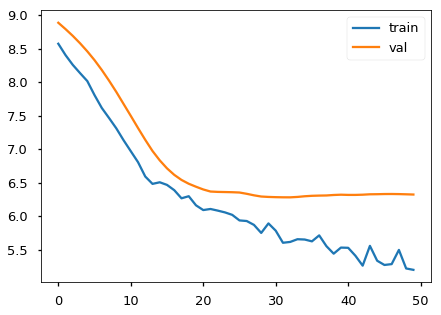

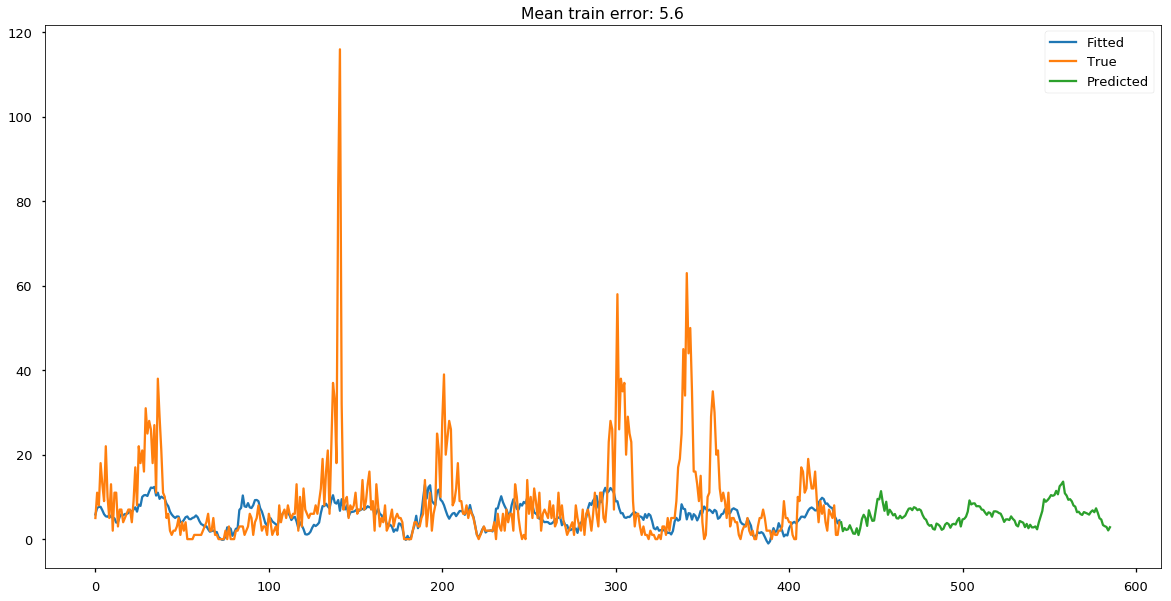

In [102]:
iq_model, iq_train_preds, iq_test_preds = fit_and_predict_LSTM(iq_feature_train.iloc[70:,:], iq_feature_test, epochs = 50, n_hidden = 40, verbose = 2)

In [60]:
output_iq = pd.DataFrame(np.append(iq_train_preds,iq_test_preds))
output_iq['total_cases'] = np.expm1(output_iq[0]).astype(int)

Text(0,0.5,'total_cases')

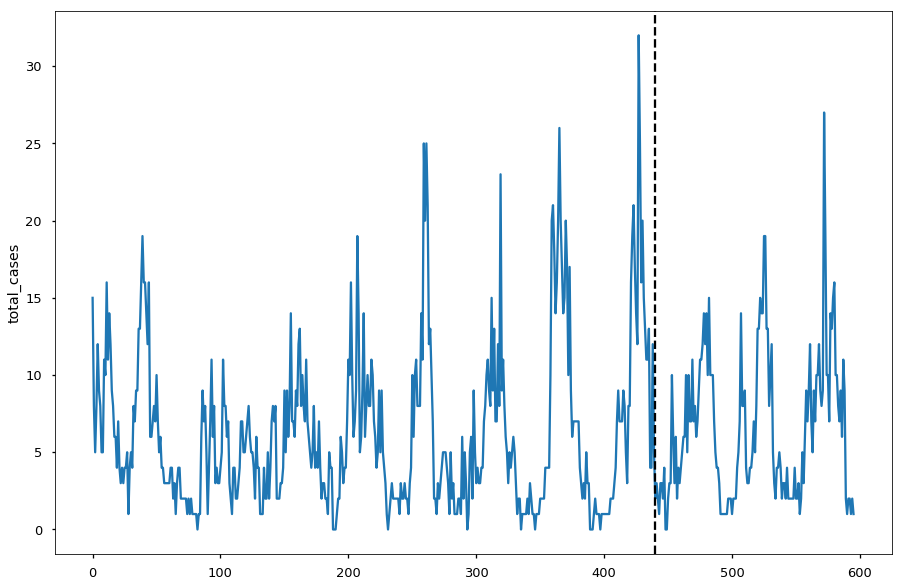

In [61]:
fig, ax = plt.subplots(figsize = (15,10))
output_iq['total_cases'].plot(ax = ax)
ax.axvline(len(iq_train_preds), linestyle = 'dashed', color = 'black')
ax.set_ylabel('total_cases')

# Create submission

In [92]:
sj_sub = pd.DataFrame(sj_test_preds.astype(int), columns = ['total_cases'])
sj_sub['year'] = sj_feature_test['year']
sj_sub['weekofyear'] = sj_feature_test['weekofyear']
sj_sub['city'] = 'sj'

In [94]:
iq_sub = pd.DataFrame(iq_test_preds.astype(int), columns = ['total_cases'])
iq_sub['year'] = iq_feature_test['year']
iq_sub['weekofyear'] = iq_feature_test['weekofyear']
iq_sub['city'] = 'iq'

In [95]:
sub = sj_sub.append(iq_sub)[['city', 'year', 'weekofyear', 'total_cases']]

In [96]:
sub.loc[sub['total_cases'] < 0, 'total_cases'] = 0

In [97]:
sub

,city,year,weekofyear,total_cases
0,sj,2008,18,1
1,sj,2008,19,1
2,sj,2008,20,2
3,sj,2008,21,5
4,sj,2008,22,4
5,sj,2008,23,4
6,sj,2008,24,10
7,sj,2008,25,4
8,sj,2008,26,8
9,sj,2008,27,14


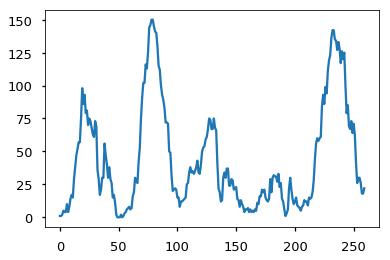

In [98]:
sub[sub['city'] == 'sj']['total_cases'].plot()

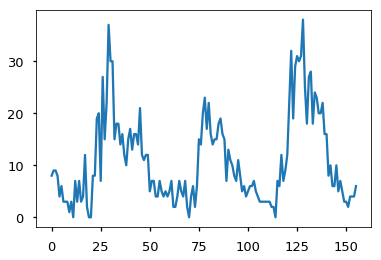

In [99]:
sub[sub['city'] == 'iq']['total_cases'].plot()

In [100]:
import time 
today = time.strftime("%d-%m-%Y")

In [101]:
sub.to_csv(submissions_path + '/Keras_LSTM_'+ output_feature_fname + '_' + today + '.csv', index = False)